<a href="https://colab.research.google.com/github/alfonsomayoral/MNIST-Handwritten-Digit-Classification-Using-a-Multi-Layer-Neural-Network/blob/main/Multilayer_Neural_Network_Classification_Handwritten_Digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Implementing a Two-Layer Neural Network for MNIST Classification**



## **Project Overview**

This project demonstrates the implementation of a two-layer neural network designed to classify handwritten digits from the MNIST dataset. This notebook is structured to showcase academic and professional competency in machine learning fundamentals. It provides detailed explanations of each step in building and training a simple neural network, with a focus on clarity, modularity, and scalability.

## Introduction and Setup
In this section, we load the required libraries necessary for data handling, visualization, and implementation of the neural network from scratch.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.datasets import mnist

# Setting up Matplotlib for inline plotting
%matplotlib inline

# Set random seed for reproducibility
np.random.seed(3)

## Load MNIST Dataset
For this project, we will use [MNIST](https://en.wikipedia.org/wiki/MNIST_database) handwritten digits data set. The dataset consists 10 handwritten digits (0,1,...,9). It is a widely used dataset to demonstrate simple image classification problem.

MNIST dataset is publicly available from different sources. We will be using MNIST from Keras package. If you do not have Keras installed, you can find the installation guide [here](https://www.tutorialspoint.com/keras/keras_installation.htm).

In short, you need to run ```conda install -c anaconda keras``` or ```pip install keras```

The training data consists of 60000 images of size $28 \times 28$ pixels; the test data consists of 10000 images.


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training data shape: (60000, 28, 28)
Test data shape: (10000, 28, 28)


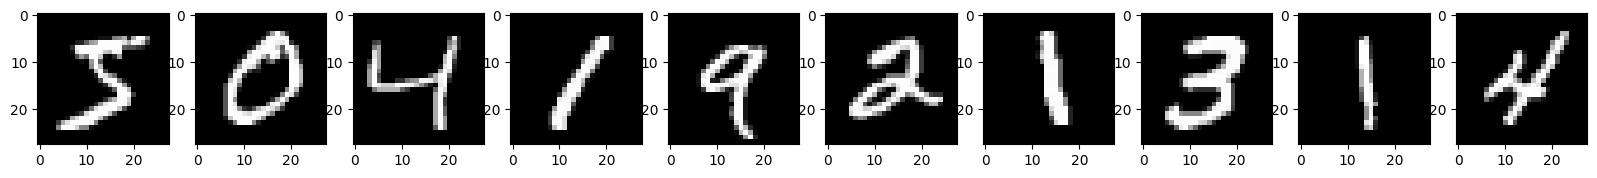

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print('Training data shape:',x_train.shape)
print('Test data shape:',x_test.shape)

n_img=10
plt.figure(figsize=(n_img*2,2))
plt.gray()
for i in range(n_img):
    plt.subplot(1,n_img,i+1)
    plt.imshow(x_train[i])
plt.show()

_We will be vectorizing the training and test images. So, the size of each vector will be 784._

In [3]:
x_train=x_train.reshape(x_train.shape[0],-1)
x_test=x_test.reshape(x_test.shape[0],-1)

print('Training data shape after reshaping:',x_train.shape)
print('Test data shape after reshaping::',x_test.shape)

Training data shape after reshaping: (60000, 784)
Test data shape after reshaping:: (10000, 784)


## Multiclass Classification
This project focuses on multiclass classification using a neural network. The network predicts probabilities for each of the ten classes, and the predicted class is the one with the highest probability.


### Model Explanation
The neural network has three layers:
1. **Input Layer**: 784 nodes (28x28 pixel values).
2. **Hidden Layer**: 256 nodes with a sigmoid activation function.
3. **Output Layer**: 10 nodes with a softmax activation function.

Now we will build a classifier to separate all the digits. For this purpose, we will only change the last layer and the loss.


Instead of using a single output, we will provide 10 outputs; and instead of using a binary cross entropy loss, we will use mutli-class cross entropy loss.

In multinomal logistic regression (aka softmax regression), we define the posterior probability of label $y \in \{0,\ldots, K-1\}$ as


$$p(y = c | \mathbf{x}) = \frac{\exp(\mathbf{w}_c^T\mathbf{x})}{\sum_{k=1}^K \exp(\mathbf{w}_k^T\mathbf{x})} = \mathbf{p}_c.$$

In other words, last layer of the network provides a probability vector $\mathbf{p} \in \mathbb{R}^K$, such that each $0 \le \mathbf{p}_c \le 1$ and $\sum_c \mathbf{p}_c = 1$.

## Softmax
Let us first define the softmax function, which is a multinomal extension of the sigmoid function that maps a vector of length $K$ to a probability vector.

The softmax function converts raw scores into probabilities, ensuring the sum of probabilities for a sample is 1.

We can define ```softmax``` function on a vector $\mathbf{z} \in \mathbb{R}^K$ as $\mathbf{p} = \text{softmax}(\mathbf{z})$:

$$\mathbf{p}_c(\mathbf{z}) = \frac{\exp(\mathbf{z}_c)}{\sum_{k=1}^K \exp(\mathbf{z}_k)}$$



In [4]:
def softmax(z):
    """Computes the softmax of the input z."""
    exp_Z = np.exp(Z)
    probs = exp_Z / np.sum(exp_Z, axis=0,keepdims=True)
    return probs

We have to note that the numerical range of floating point numbers in numpy is limited. For `float64` the upper bound is $10^{308}$. For exponential, its not difficult to overshoot that limit, in which case python returns `nan`.

To make our softmax function numerically stable, we simply normalize the values in the vector, by multiplying the numerator and denominator with a constant `C` as

\begin{align*}
\mathbf{p}_c  &= \frac{\exp(\mathbf{z}_c)}{\sum_{k=1}^K \exp(\mathbf{z}_k)} \\
& = \frac{C\exp(\mathbf{z}_c)}{C\sum_{k=1}^K \exp(\mathbf{z}_k)}\\
& = \frac{\exp(\mathbf{z}_c + \log C)}{\sum_{k=1}^K \exp(\mathbf{z}_k + \log C)}.
\end{align*}

We can choose an arbitrary value for `log(C)` term, but generally `log(C) = −max(z)` is chosen


### Stable Softmax function


In [5]:
def stable_softmax(Z):
    # Z -- K x N numpy.ndarray, K is the number of classes, N is the number of samples
    Z_stable = Z - np.max(Z, axis=0, keepdims=True)
    exp_Z_stable = np.exp(Z_stable)
    probs = exp_Z_stable / np.sum(exp_Z_stable, axis=0, keepdims=True)

    return probs

**Derivative of the softmax function**

We can show that the derivative of the __softmax__ function with respect to any input can be written as

$$ \frac{\partial \mathbf{p}_i}{\partial \mathbf{z}_j} = \begin{cases} \mathbf{p}_i(1-\mathbf{p}_j) & i = j \\ \mathbf{p}_i (-\mathbf{p}_j) & i \ne j. \end{cases}$$

[More info here](https://deepnotes.io/softmax-crossentropy)

## Multiclass Cross Entropy Loss Function
We will minimize the cross entropy loss. You will use the true labels and predicted labels of a batch of N samples.

The multi-class cross entropy loss for $i^{th}$ sample can be written as
$$Loss_i = -\sum_c \mathbf{1}(y_i = c) \log \mathbf{p}_c $$
where $y_i$ is the true label and

$$\mathbf{1}(y_i = c) = \begin{cases} 1 & y_i =c \\ 0 & \text{otherwise} \end{cases}$$
is an indicator function.

We can find the average loss for a batch of N samples as $Loss=\frac{1}{N}\sum_{i=1}^{N} Loss_i$.


In [6]:
def MultiClassCrossEntropyLoss(Y_true, probs):

  # probs -- K x N array
  # Y_true -- 1 x N array
  # loss --  sum Loss_i over N samples

  N = Y_true.shape[1]
  Y_one_hot = np.zeros_like(probs)
  Y_one_hot[Y_true, np.arange(N)] = 1
  loss = -np.sum(Y_one_hot * np.log(probs + 1e-15)) / N

  return loss

### Derivative of the multi-class cross entropy loss

Let us assume that $\mathbf{p} = \text{softmax}(\mathbf{z})$.

Note that the derivative of the loss w.r.t. $\mathbf{p}_j$ can be written as
$$\frac{\partial Loss_i }{\partial \mathbf{p}_j} = \begin{cases} -1/\mathbf{p}_j & j = y_i \\ 0 & j \ne y_i \end{cases}. $$

Note that we can use _total derivative_ to compute the derivative of the loss for $i$th sample w.r.t. $j$th entry in $\mathbf{z}$ as

\begin{align*}
\frac{\partial Loss_i}{\partial \mathbf{z}_j} = \sum_c \frac{\partial Loss_i}{\partial \mathbf{p}_c}\frac{\partial \mathbf{p}_c}{\partial \mathbf{z}_j}.
\end{align*}

From our discussion above, we know that the $\frac{\partial Loss_i}{\partial \mathbf{p}_c} = 0$ if $c \ne y_i$.


\begin{align*}
\frac{\partial Loss_i}{\partial \mathbf{z}_j} &= -\frac{1}{\mathbf{p}_c} \frac{\partial \mathbf{p}_c}{\partial \mathbf{z}_j} \\
& = \begin{cases} \mathbf{p}_j - 1 & j = y_i \\ \mathbf{p}_j & j \ne y_i. \end{cases}
\end{align*}

Therefore, $$\delta^{(2)} = \nabla_{\mathbf{z}^{(2)}} Loss_i = \mathbf{p} - \mathbf{1}_{y_i}.$$

where $\mathbf{1}_{y_i}$ is a __one-hot vector__ that has length $K$ and is zero everywhere except 1 at index same as $y_i$.


## Training Data
We will prepare training data by ensuring an equal representation of all classes and normalizing pixel values.

Let us pick training data for multi-class classification.

Pick same number of images from each class for training and create arrays for input and output.

```
# train_x -- N x 784 array of training input
# train_y -- N x 1 array of labels
```  

If you use 1000 images from each class N = 10000 (1000 * 10). You can increase the number of training samples if you like. You may also use unequal number of images in each class.

We also need to transpose the dimension of the data so that their size becomes $784\times N$. It will be helpful to feed it to our model based on our notations.

In [7]:
# Pick training samples
num_samples = 1000

# Training data
x = np.zeros((0,784))
y = np.zeros((0))
for label in range(10):
  x1 = x_train[y_train == label]
  x1 = x1[:num_samples]
  y1 = y_train[y_train == label]
  y1 = y1[:num_samples]

  x = np.concatenate((x,x1),axis=0)
  y = np.concatenate((y,y1),axis=0)

train_x = x
train_y = y
print("Training data shape:", train_x.shape)


# Test data
test_x = x_test
test_y = y_test
print("Test data shape:", test_x.shape)

# reshape data
train_x = train_x.T
test_x = test_x.T
print("Training data shape:", train_x.shape)
print("Test data shape:", test_x.shape)

Training data shape: (10000, 784)
Test data shape: (10000, 784)
Training data shape: (784, 10000)
Test data shape: (784, 10000)


In [8]:
# You can convert the array of labels into an array of one hot vectors as follows
N = len(train_y)
onehot_y = np.zeros((10,N))
onehot_y[train_y.astype(int),np.arange(N)] = 1

## Network Architecture
We will be using a two layer neural network in our experiment. The input layer has 784 nodes, the hidden layer will have 256 nodes and the output layer will have 10 nodes. First layer will have __sigmoid__ activation and second layer will have __softmax__ activation.

The equations for feedforward operation will be as follows.

$$\mathbf{z}^{(1)}=W^{(1)} \mathbf{x}+ \mathbf{b}^{(1)}\\\mathbf{y}^{(1)}=\text{sigmoid}(\mathbf{z}^{(1)})\\\mathbf{z}^{(2)}=W^{(2)}  \mathbf{y}^{(1)}+ \mathbf{b}^{(2)} \\\mathbf{p} = \mathbf{y}^{(2)}=\text{softmax}(\mathbf{z}^{(2)})$$

where $\mathbf{x}\in \mathbb{R}^{784}$ is the input layer, $\mathbf{y}^{(1)}\in \mathbb{R}^{256}$ is the hidden layer, $\mathbf{y}^{(2)} \in \mathbb{R}$ is the output layer, $W^{(1)}\in \mathbb{R}^{256\times 784}$ is the first layer weights, $W^{(2)}\in \mathbb{R}^{10\times 256}$ is the second layer weights, $\mathbf{b}^{(1)}\in \mathbb{R}^{256}$ is the first layer bias, $\mathbf{b}^{(2)}\in \mathbb{R}^{10}$ is the second layer bias vector.


## Network Initialization

We initialize the weights for $W^{(1)}$ and $W^{(2)}$ with random values drawn from normal distribution with zero mean and 0.01 standard deviation. We will initialize bias vectors $\mathbf{b}^{(1)}$ and $\mathbf{b^{(2)}}$ with zero values.

We can fix the seed for random initialization for reproducibility.

In [9]:
def TwoLayerNetwork(layer_dims=[784,256,10]):

    #Initialize the weights
    params = {
        'W1': np.random.randn(layer_dims[1], layer_dims[0]) * 0.01,
        'b1': np.zeros((layer_dims[1], 1)),
        'W2': np.random.randn(layer_dims[2], layer_dims[1]) * 0.01,
        'b2': np.zeros((layer_dims[2], 1))
    }

    return params

## Forward Propagation
Next, we will write the code for the forward pass for two layer network. Each layer consists of an affine function (fully-connected layer) followed by an activation function. You wil also return the intermediate results ($\mathbf{x}, \mathbf{z}^{(1)}, \mathbf{y}^{(1)}, \mathbf{z}^{(2)}$) in addition to final output ($\mathbf{y}^{(2)}$). You will need the intermediate outputs for the backpropagation step.

In [10]:
def forward(X, params):

    # X -- 784 x N array
    # params --
      # W1 -- 256 x 784 matrix
      # b1 -- 256 x 1 vector
      # W2 -- 10 x 256 matrix
      # b2 -- 10 x 1 scalar
    # probs -- 10 x N output

    W1, b1, W2, b2 = params['W1'], params['b1'], params['W2'], params['b2']

    Z1 = np.dot(W1, X) + b1
    Y1 = 1 / (1 + np.exp(-Z1))

    Z2 = np.dot(W2, Y1) + b2
    exp_Z2 = np.exp(Z2 - np.max(Z2, axis=0, keepdims=True))
    probs = exp_Z2 / np.sum(exp_Z2, axis=0, keepdims=True)

    intermediate = {
        'X': X,
        'Z1': Z1,
        'Y1': Y1,
        'Z2': Z2
    }

    return probs, intermediate

## Backward Propagation

Now we will implement the backpropagation step for the two layer neural network using softmax layer and loss function.


You will need the gradient of the Loss w.r.t. $W^{(l)},\mathbf{b}^{(l)}$ for $l = 1,2$ for all the training samples.  

We saw that we can write the gradient of Loss with respect to $W^{(l)}, \mathbf{b}^{(l)}$ for a single sample as

$$\nabla_{W^{(l)}} Loss_i = \delta^{(l)} \mathbf{y}^{(l-1)T},$$  
$$\nabla_{\mathbf{b}^{(l)}} Loss_i = \delta^{(l)},$$


where
$$\delta^{(l)} = \nabla_{\mathbf{z}^{(l)}} Loss = \nabla_{\mathbf{y}^{(l)}} Loss \odot \varphi'(\mathbf{z}^{(l)}).$$

We saw above that for an $i$th sample, $\delta^{(2)} = \nabla_{\mathbf{z}^{(2)}} Loss_i = \mathbf{p} - \mathbf{1}_{y_i},$ where $\mathbf{1}_{y_i}$ is a __one-hot vector__ that has length $K$ and is zero everywhere except 1 at index same as $y_i$ and $\mathbf{p}$ is the outpu probability vector for the $i$th sample.

Recall that for the intermediate layers $l<L$, we can write
$$\delta^{(l)} = W^{(l+1)T}\delta^{(l+1)} \odot \varphi'(\mathbf{z}^{(l)}).$$




**Once we have the gradients $\nabla_{W^{(l)}} Loss_i, \nabla_{\mathbf{b}^{(l)}} Loss_i$ for all $i$. We can compute their average to compute the gradient of the total loss function as**

$$\nabla_{W^{(l)}} Loss = \frac{1}{N} \sum_i \nabla_{W^{(l)}} Loss_i, $$
$$ \nabla_{\mathbf{b}^{(l)}} Loss = \frac{1}{N} \sum_i  \nabla_{\mathbf{b}^{(l)}} Loss_i.$$

**Please refer to the slides and lectures for more details.**


In [11]:
def backward(Y_true, probs, intermediate, params):

    # Inputs:
      # Y_true -- true labels
      # probs -- 10 x N output of the last layer
      # intermediate -- X, Z1, Y1, Z2
      # params -- W1, b1, W2, b2

    # Outputs:
      # grads -- [grad_W1, grad_b1, grad_W2, grad_b2]

    X, Z1, Y1, Z2 = intermediate['X'], intermediate['Z1'], intermediate['Y1'], intermediate['Z2']
    W1, b1, W2, b2 = params['W1'], params['b1'], params['W2'], params['b2']
    N = X.shape[1]

    delta2 = probs - Y_true  # 10 x N

    grad_W2 = np.dot(delta2, Y1.T) / N  # 10 x 256
    grad_b2 = np.sum(delta2, axis=1, keepdims=True) / N  # 10 x 1

    delta1 = np.dot(W2.T, delta2) * Y1 * (1 - Y1)  # 256 x N

    grad_W1 = np.dot(delta1, X.T)   # 256 x 784
    grad_b1 = np.sum(delta1, axis=1, keepdims=True) / N  # 256 x 1

    grads = {
        'grad_W1': grad_W1,
        'grad_b1': grad_b1,
        'grad_W2': grad_W2,
        'grad_b2': grad_b2
    }


    return grads

## Train the Model
We will use the forward and backward functions defined above with the same optimizer defined in the previous question to train our multi-class classificaiton model.

We will specify the number of nodes in the layers, number of epochs and learning rate and initialize the network

In [23]:
layer_dims = [train_x.shape[0],256,10]
epochs = 100
lr = 0.00001

params = TwoLayerNetwork(layer_dims)

Then we train the network for the number of epochs specified above. In every epoch, we will do the following:
1. Calculate the forward pass to get estimated labels.
2. Use the estimated labels calculate loss. We will be recording loss for every epoch.
3. Use backpropagation to calculate gradients.
4. Use gradient descent to update the weights and biases.

You should store the loss value after every epoch in an array ```loss_history```  and print the loss value after every few epochs (say 20).

In [24]:
loss_history = []

# Train of the network
for epoch in range(epochs):
    probs, intermediate = forward(train_x, params)

    loss = -np.sum(np.log(probs[train_y.astype(int), np.arange(probs.shape[1])])) / train_x.shape[1]
    loss_history.append(loss)

    grads = backward(onehot_y, probs, intermediate, params)

    params['W1'] -= lr * grads['grad_W1']
    params['b1'] -= lr * grads['grad_b1']
    params['W2'] -= lr * grads['grad_W2']
    params['b2'] -= lr * grads['grad_b2']

    # We show the loss every 20 epochs.
    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss}")

Epoch 0, Loss: 2.3082227686946224
Epoch 20, Loss: 1.8291693247783107
Epoch 40, Loss: 1.7463964191789476
Epoch 60, Loss: 1.7079657637618277
Epoch 80, Loss: 1.6848225913124715


Now we will plot the recorded loss values vs epochs. We will observe the training loss decreasing with the epochs.

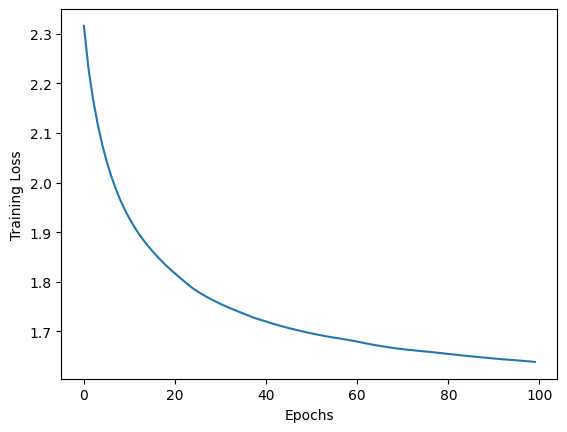

In [14]:
plt.figure()
plt.plot(loss_history)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.show()

## Evaluation on Test Data

Now we will be evaluating the accuracy we get from the trained model. We feed training data and test data to the forward model along with the trained parameters.

Note that, we need to convert the (probability) output of the forward pass into labels before evaluating accuracy. We can assign label based on the maximum probability.

We assign estimated labels $$\hat{y}_i = \arg \max_c  \mathbf{p}_c $$ for every probility vector.

In [15]:
train_probs, _ = forward(train_x, params)
train_pred = np.argmax(train_probs, axis=0)
train_accuracy = np.mean(train_pred == train_y) * 100
print("Training accuracy:", train_accuracy)

test_probs, _ = forward(test_x, params)
test_pred = np.argmax(test_probs, axis=0)
test_accuracy = np.mean(test_pred == test_y) * 100
print("Test accuracy:", test_accuracy)

Training accuracy: 89.60000000000001
Test accuracy: 87.91


## Visualize some of the correct/miscalassified images

Now we will look at some images from training and test sets that were misclassified in both training and test set

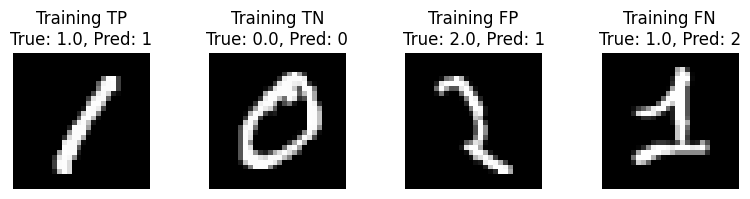

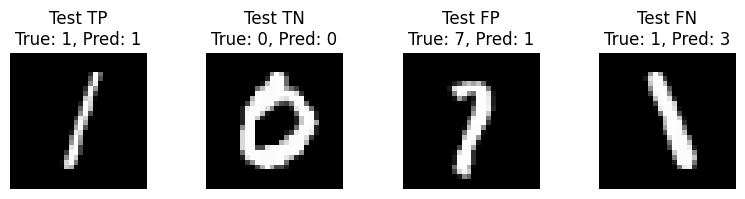

In [16]:
def get_classification_example(X, Y_true, params):
    probs, _ = forward(X, params)
    Y_pred = np.argmax(probs, axis=0)
    examples = {'TP' : None, 'TN' : None,  'FP' : None,  'FN' : None, }

    for i in range(Y_true.shape[0]):
        true_label = Y_true[i]
        predicted_label = Y_pred[i]

        if true_label == predicted_label:
            if true_label == 1 and examples['TP'] is None:
                examples['TP'] = (X[:,i], true_label, predicted_label)
            elif true_label == 0 and examples['TN'] is None:
                examples['TN'] = (X[:,i], true_label, predicted_label)
        else:
            if true_label == 1 and examples['FN'] is None:
                examples['FN'] = (X[:,i], true_label, predicted_label)
            elif predicted_label == 1 and examples['FP'] is None:
                examples['FP'] = (X[:,i], true_label, predicted_label)

        # Salir si ya se han encontrado todos los ejemplos
        if all(v is not None for v in examples.values()):
            break

    return examples


train_example = get_classification_example(train_x, train_y, params)
test_example = get_classification_example(test_x, test_y, params)

def plot_classification_example(example, dataset):
    plt.figure(figsize = (8,2))
    for j, label in enumerate(['TP', 'TN', 'FP', 'FN']):
        if example[label] is not None:
            img, true_label, pred_label = example[label]
            img = img.reshape(28, 28)
            plt.subplot(1, 4, j+1)
            plt.imshow(img, cmap='gray')
            plt.title(f"{dataset} {label}\nTrue: {true_label}, Pred: {pred_label}")
            plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_classification_example(train_example, "Training")
plot_classification_example(test_example, "Test")

Below we will calculate the confusion matrix elements (True Positives, True Negatives, False Positives, and False Negatives) for a binary classification task. It uses the ```count_confusion_matrix_elements``` function to compare the true labels (```Y_true```) with the predicted labels (```Y_pred```), incrementing the appropriate counts (TP, TN, FP, FN) based on whether the model's predictions are correct or incorrect. These counts are then returned in a dictionary.

The ```plot_confusion_and_bar``` function visualizes the confusion matrix by creating a bar chart and a heatmap. The bar chart shows the counts of TP, TN, FP, and FN, while the heatmap displays the confusion matrix with annotations for each element. This function is called for both the training and testing datasets to provide insights into the model's performance.

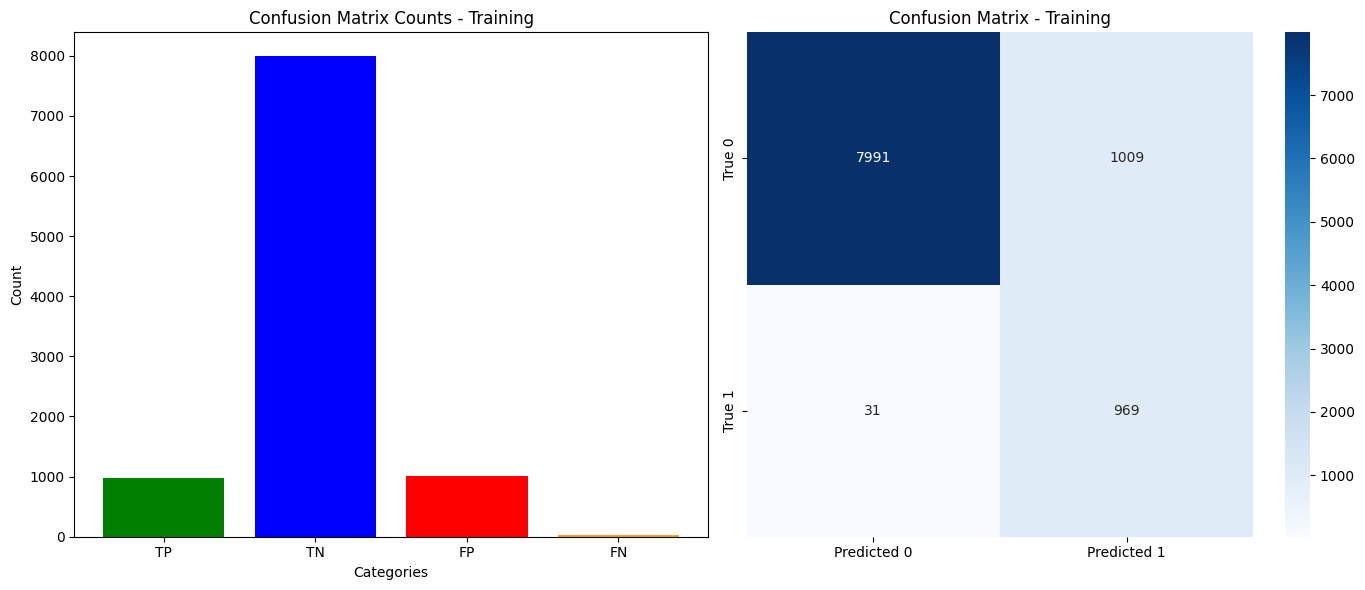

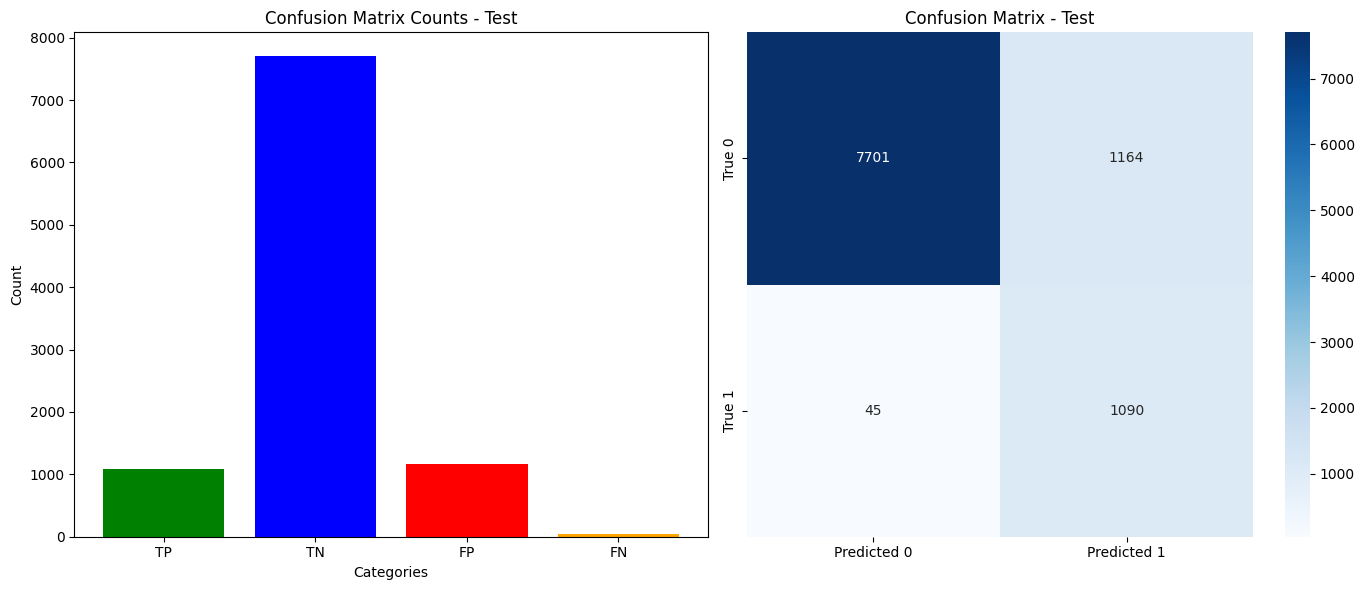

In [17]:
def count_confusion_matrix_elements(X, Y_true, params):
    probs, _ = forward(X, params)
    Y_pred = np.argmax(probs, axis=0)
    counts = {'TP': 0, 'TN': 0, 'FP': 0, 'FN': 0}

    for i in range(Y_true.shape[0]):
        true_label = Y_true[i]
        predicted_label = Y_pred[i]
        if true_label == predicted_label:
            if true_label == 1:
                counts['TP'] += 1
            else:
                counts['TN'] += 1
        else:
            if true_label == 1:
                counts['FN'] += 1
            else:
                counts['FP'] += 1

    return counts

# Obtener los conteos de la matriz de confusión
train_counts = count_confusion_matrix_elements(train_x, train_y, params)
test_counts = count_confusion_matrix_elements(test_x, test_y, params)

# Graficar la matriz de confusión como un mapa de calor
def plot_confusion_and_bar(counts, dataset_name):
    # Definir las etiquetas y valores para la barra
    labels = ['TP', 'TN', 'FP', 'FN']
    values = [counts['TP'], counts['TN'], counts['FP'], counts['FN']]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Gráfico de barras
    ax1.bar(labels, values, color=['green', 'blue', 'red', 'orange'])
    ax1.set_title(f'Confusion Matrix Counts - {dataset_name}')
    ax1.set_ylabel('Count')
    ax1.set_xlabel('Categories')

    # Matriz de confusión (mapa de calor)
    conf_matrix = np.array([[counts['TN'], counts['FP']], [counts['FN'], counts['TP']]])
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'], ax=ax2)
    ax2.set_title(f'Confusion Matrix - {dataset_name}')

    plt.tight_layout()
    plt.show()

# Graficar para el conjunto de entrenamiento y prueba
plot_confusion_and_bar(train_counts, "Training")
plot_confusion_and_bar(test_counts, "Test")

And now we will visualize confusion matrices for each class in a multi-class classification task. The ```plot_confusion_matrices``` function first calculates the predicted probabilities (```probs```) for each class and then determines the predicted class labels (```Y_pred```). For each class, it binarizes the true and predicted labels (one-vs-all approach), and calculates the confusion matrix for that class using ```confusion_matrix()```. It then plots each confusion matrix as a heatmap for every class in separate subplots.

The heatmap shows the count of True Positives, True Negatives, False Positives, and False Negatives for each class. The function creates a grid of subplots, where each subplot displays the confusion matrix for one class. This process is repeated for both the training and test datasets, providing a detailed visualization of the model's performance for each class in the classification task.

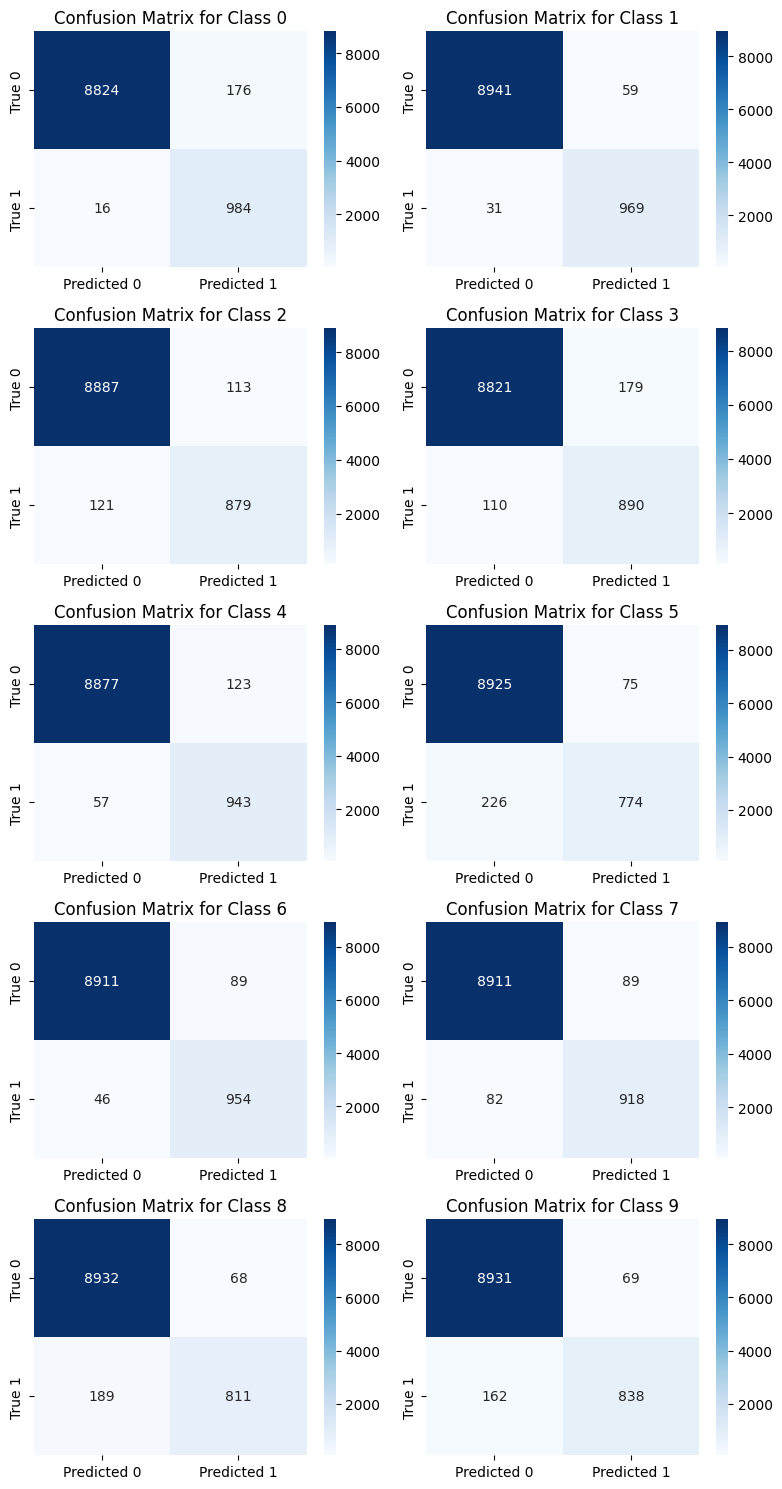

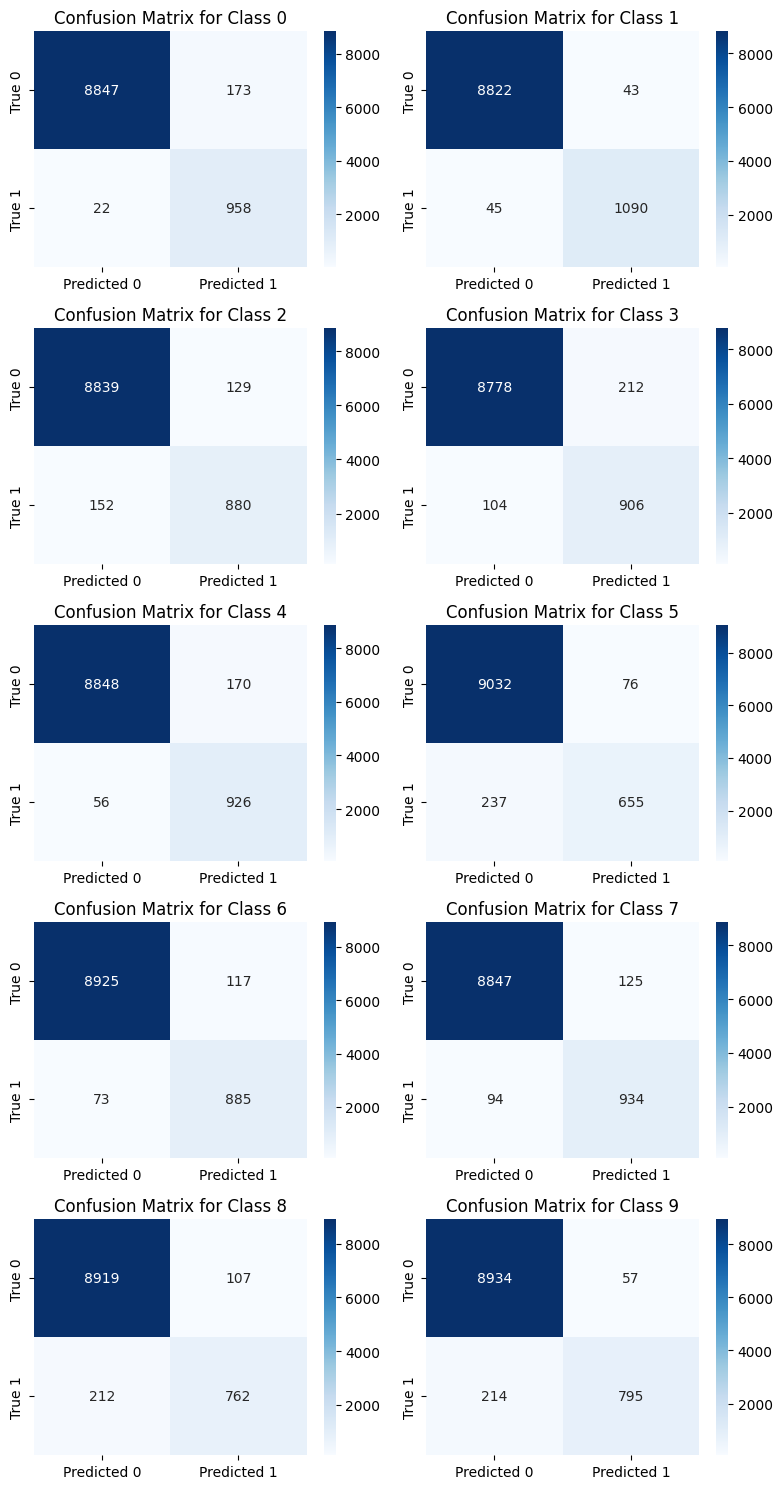

In [19]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrices(X, Y_true, params, n_classes):
    # Calcular las probabilidades de predicción
    probs, _ = forward(X, params)
    Y_pred = np.argmax(probs, axis=0)

    # Binarizar las etiquetas verdaderas para cada clase (one-vs-all)
    fig, axes = plt.subplots(n_classes // 2, 2, figsize=(8, 3 * (n_classes // 2)))
    axes = axes.flatten()  # Flatten para facilitar el acceso a los ejes

    for i in range(n_classes):
        # Binarizar las etiquetas verdaderas para la clase i
        Y_true_bin = (Y_true == i).astype(int)
        Y_pred_bin = (Y_pred == i).astype(int)

        # Calcular la matriz de confusión
        cm = confusion_matrix(Y_true_bin, Y_pred_bin)

        # Graficar la matriz de confusión como mapa de calor
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'], ax=axes[i])
        axes[i].set_title(f'Confusion Matrix for Class {i}')

    plt.tight_layout()
    plt.show()

# Definir el número de clases
n_classes = len(np.unique(train_y))

# Graficar las matrices de confusión para el conjunto de entrenamiento
plot_confusion_matrices(train_x, train_y, params, n_classes)

# Graficar las matrices de confusión para el conjunto de prueba
plot_confusion_matrices(test_x, test_y, params, n_classes)

Finally, we will implement the visualization of Receiver Operating Characteristic (ROC) curves and calculates the Area Under the Curve (AUC) for a multi-class classification problem. It will generate an ROC curve for each class, showing the trade-off between the False Positive Rate (FPR) and True Positive Rate (TPR). Additionally, it computes and displays the AUC for each class, which summarizes the performance of the classifier across different thresholds.

The function will plot the ROC curves for both the training and test datasets, allowing a visual comparison of the model's performance across classes. The AUC for each class will be printed for both datasets, providing a numerical summary of the classifier's effectiveness for each individual class.

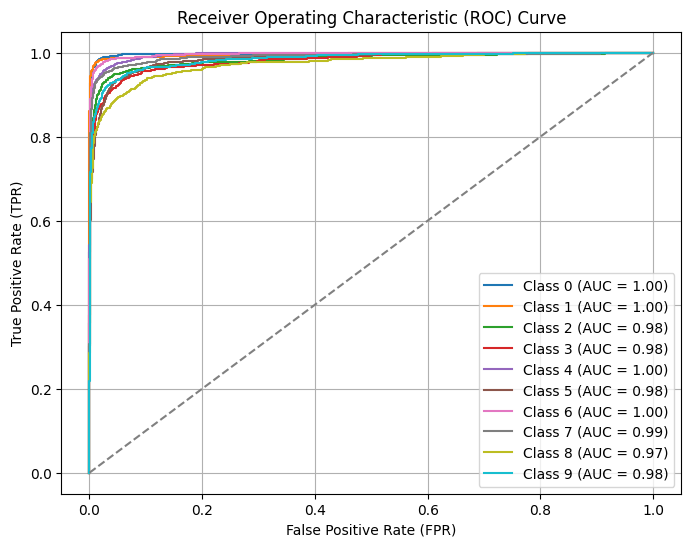

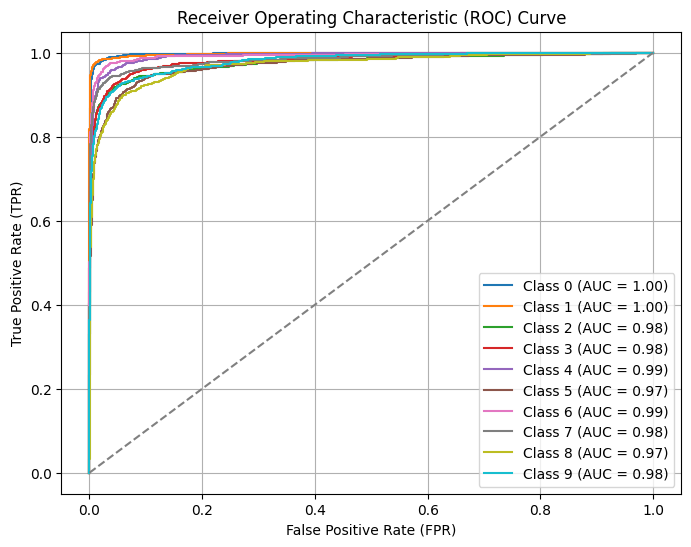

Train AUC for Class 0: 1.00
Test AUC for Class 0: 1.00
Train AUC for Class 1: 1.00
Test AUC for Class 1: 1.00
Train AUC for Class 2: 0.98
Test AUC for Class 2: 0.98
Train AUC for Class 3: 0.98
Test AUC for Class 3: 0.98
Train AUC for Class 4: 1.00
Test AUC for Class 4: 0.99
Train AUC for Class 5: 0.98
Test AUC for Class 5: 0.97
Train AUC for Class 6: 1.00
Test AUC for Class 6: 0.99
Train AUC for Class 7: 0.99
Test AUC for Class 7: 0.98
Train AUC for Class 8: 0.97
Test AUC for Class 8: 0.97
Train AUC for Class 9: 0.98
Test AUC for Class 9: 0.98


In [20]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
def plot_roc_auc_multiclass(X, Y_true, params, n_classes):
    # Calcular las probabilidades de predicción
    probs, _ = forward(X, params)

    # Binarizar las etiquetas verdaderas (para casos multiclase)
    Y_true_bin = label_binarize(Y_true, classes=np.arange(n_classes))

    # Graficar la curva ROC para cada clase
    plt.figure(figsize=(8, 6))
    roc_auc = dict()
    for i in range(n_classes):
        # Calcular la curva ROC y el AUC para la clase i
        fpr, tpr, _ = roc_curve(Y_true_bin[:, i], probs[i, :])
        roc_auc[i] = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    # Línea diagonal de referencia
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    return roc_auc

# Definir el número de clases
n_classes = len(np.unique(train_y))

# Graficar ROC y AUC para el conjunto de entrenamiento
train_roc_auc = plot_roc_auc_multiclass(train_x, train_y, params, n_classes)

# Graficar ROC y AUC para el conjunto de prueba
test_roc_auc = plot_roc_auc_multiclass(test_x, test_y, params, n_classes)

# Imprimir AUC por clase
for i in range(n_classes):
    print(f"Train AUC for Class {i}: {train_roc_auc[i]:.2f}")
    print(f"Test AUC for Class {i}: {test_roc_auc[i]:.2f}")

In [ ]:
!sudo apt-get update
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic pandoc
!pip install pypandoc

In [ ]:
!jupyter nbconvert --log-level DEBUG --to pdf "Multilayer_Neural_Network_Classification_Handwritten_Digits.ipynb"